In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle as pickle
import gzip 
from pylab import *
from __future__ import division

###  Load data

In [43]:
# Load a list of neuron data
PN_data = pickle.load(gzip.open('Data/PNdata.pklz'))
pulse_labelsPN = pickle.load(gzip.open('Data/pulselabelsPN.pklz','rb'))
number_of_datasetsPN = 5

LN_data = pickle.load(gzip.open('Data/LNdata.pklz','rb'))
pulse_labelsLN = pickle.load(gzip.open('Data/pulselabelsLN.pklz','rb'))
number_of_datasetsLN = 8

# Load the holfing currents for LNs 
holding_currents = array([34,-66,-110,20,-120,-86,-52,-104])

#### Important Parameters

In [44]:
f_s = 20000 #sampling frequency (Hz)
dt = 1/float(f_s)


stim_start_PN = 3 #seconds
stim_end_PN   = 8 #seconds
sweep_length_PN = 11 #seconds

idx_stim_start_PN = int(stim_start_PN/dt)
idx_stim_end_PN =   int(stim_end_PN/dt)

sweep_length_LN = 8 #seconds
stim_start_LN = 1 #seconds
stim_end_LN   = 5 #seconds
time_LN = linspace(0,sweep_length_LN,sweep_length_LN*f_s)

idx_stim_start_LN = int(stim_start_LN/dt)
idx_stim_end_LN =   int(stim_end_LN/dt)

### Select 'Good' Neurons

The reasons as to why these neurons were chosen are explored below

#### LNs, with a no-stim sweep and a subthreshold sweep : 


In [104]:
# 1st, 6th, 7th

LN_data_sel = [LN_data[nidx] for nidx in (0,5,6)]
LN_data_sel = array(LN_data_sel)

#### PNs, subthreshold sweep :

In [111]:
# 2nd, 3rd, 4th

PN_data_sel = [PN_data[nidx] for nidx in (2,3,4)]
PN_data_sel = array(PN_data_sel)

In [106]:
# Data Structure
# print the data for the first PN (array: sweeps x time samples)
PN_data[0].shape

print '(#of sweeps,','#number of datapoints)'
print 'data for PNs'
for data in PN_data:
    print data.shape
    
print 'data for LNs'   
for data in LN_data:
    print data.shape

(#of sweeps, #number of datapoints)
data for PNs
(8, 220000)
(5, 220000)
(7, 220000)
(8, 220000)
(5, 220000)
data for LNs
(11, 160000)
(15, 160000)
(18, 160000)
(20, 160000)
(8, 160000)
(12, 160000)
(9, 160000)
(10, 160000)


# Contents 

- [leak potential](#Leak-Potential-$E_l$)
- [threshold potential](#Threshold-Potential-$V_{th}$)
- [time constant](#Time-Constant-$\tau_m$)
- [membrane resistance](#Membrane-Resistance-$R_m$)
- [membrane capacitance](#Membrane-Capacitance-$C_m$)
- [leak potential and holding current](#Leak-Potential-$E_l$-&-Holding-Current)
- [Single Neuron Model](#Single-Neuron-Model)

### Leaky Integrate and Fire Model (LIF)

The leaky integrate and fire model consists of a 1st order inhomogenous differential equation and a fire & reset rule. $$C_m\frac{dV_m}{dt} = g_l(E_l - V_m) $$

1. $C_m$ : membrane capacitance
2. $V_m$ : membrane potential
3. $g_l$ : membrane conductance ($1/R_m$ - membrane resistance)
4. $E_l$ : leak potential (i.e. potential when membrane is at rest)


When the membrane voltage exceeds a certain threshold, $V_{th}$, we observe a spike followed by a reset of membrane potential to the reset potential $V_{res}$, followed by a refractory period in which a spike cannot be observed.

This allows us to rewrite our differential equation as.

$$  
    \frac{dV_m}{dt}=\left\{
                \begin{array}{ll}
                  \frac{1}{\tau_m} (-V_m + IR_m), t>t_{rest}\\
                  E_l, otherwise\\
                \end{array}
              \right.
$$

with a solution given by.

$$V(t) = V_{eq} (1-\exp({\frac{-t}{\tau_m}})) + R_m I ( 1-\exp({\frac{-t}{\tau_m}}))$$

for long times this reduces to

$$V_h = E_l + R_mI_h $$where $$V(t \rightarrow \infty) = V_h $$




1. $\tau_m$ : membrane time constant
2. $V_h$ : holding potential
3. $I_h$ : holding current

 
To fit a LIF model to Jan's recorded data for LNs and PNs, we need to extract the model parameters. Specifically,

1. $V_{th}$
2. $V_{res}$
3. $\tau_m$
4. $R_m$
5. $C_m$

### Parameter Extraction



In [107]:
def local_maxima(d):
    '''
    returns bool array with the same shape as `d` with elements at the position of local maxima in `d` are set to `True`
    this function simply checks if the neighbouring elements are smaller or equal and is __sensitive to noise__
    '''
    return r_[True, d[1:] >= d[:-1]] & r_[d[:-1] > d[1:], True]

 #### Reset Potential $V_{res}$ & Leak Potential $E_l$

__Reset potential__ $V_{res}$ can be calculated from the minimum of the membrane potential after a spike has occurred. We can look at these minimas for a a particular sweep and use them to calculate an average and a standard deviation. Here it is calculated using the ```reset ``` function.




In [108]:
def reset(sweep):
    """
    Function to take an input of a sweep and return an integer value of the mean reset potential for that sweep 
    along with its standard deviation in mV.
    
    Inputs:
    -------
    sweep : array like
    
    Outputs:
    --------
    Mean Reset Potential : float
    Standard Dev of Reset Potential : float
    
    """
    dt = 1/20000 #1/sampling rate (Hz)
    th = 0 # use threshold of 0 mV for AP detection. the AP waveform is not very noise so the below works
    
    V = sweep
    V_maxima = (local_maxima(V) & (V>th))
    indices = V_maxima.nonzero()[0]
    
    chunk_list = [] #chunk of spectrum for each action potential
    time_list = [] #the times for each action potential

    ten_ms = dt*200 #10 ms in terms of dt

    ten_ms_idx = int(ten_ms/dt)#10 ms in terms of indices

    for index in indices:
        start = index-ten_ms_idx
        end = index+ten_ms_idx
        chunk = V[start:end]
        time = np.arange(start,end)
        chunk_list.append(chunk)
        time_list.append(time)    
        
    average_waveform = np.mean(chunk_list,axis = 0) #calculating the average waveform by averaging over the chunks

    time = len(average_waveform)*dt
    time = np.arange(0,time,dt)

    reordered_chunks = [[] for x in xrange(len(average_waveform))] 

    for waveform in range(len(chunk_list)):
        for chunk in range(len(average_waveform)):
            reordered_chunks[chunk].append(chunk_list[waveform][chunk])

    mean_waveform = []
    std_dev = []

    for chunk in range(len(reordered_chunks)):
        mean_waveform.append(np.mean(reordered_chunks[chunk]))
        std_dev.append(np.std(reordered_chunks[chunk]))

    return float(format(min(mean_waveform),'.3f'))*1e3,float(format(max(std_dev),'.3f'))*1e3
    


Now using the above function we can find estimates of the reset potential for the two different kinds of neuron for the neurons which we've selected to examine.

In [110]:
#have to select sweeps that are spiking - can in general choose last sweep as this always 
#spikes, however doing so might not be a good idea, as we shall see neurons physically 
#deprecate as the number of sweeps gets too high

#PNs
#generally start spiking for 4th sweep for selected neurons. (see Data_Overview notebook)

PN_resets = [reset(PN_data_sel[nidx][3]) for nidx in (0,1,2)]

print PN_resets #mV

#LNs
#generally all are spiking by the 6th sweep for the selected neurons ("" "")

LN_resets = [reset(LN_data_sel[nidx][5]) for nidx in (0,1,2)]

print LN_resets #mV

[(-67.0, 2.0), (-67.0, 6.0), (-66.0, 7.0)]
[(-57.0, 3.0), (-61.0, 4.0), (-55.0, 5.0)]


### [Leak Potential $E_l$](#Contents)

__Leak potential__ $E_l$ can be calculated from the mean of the membrane potential pre-stimulation. Here it is calculated using the ```equilibium ``` function.

can extend the ```equilibrium ``` function above with the ```mean_equilibrium``` function, which can find the average of the equilibrium potential over all the sweeps of a particular recording.



In [51]:
def equilibrium(sweep,stim_start, dt = 1/20000):
    """
    function that takes a particular sweep as an input, and returns the equilibrium in mV
    
    Inputs:
    -------
    sweep : array of a particular sweep (mV)
    stim_start : float time at which stimulation started (s)
    
    Outputs:
    --------
    mean reset potential : float (mV)
    standard deviation of reset potential : float (mV)
    mean membrane potential : float (mV)
    standard deviation of membrane potential : float (mV)
    
    """

    
    V = sweep
    
    idx_stim_start = int(stim_start/dt)

    V_sub_before = V[:idx_stim_start]
    
    return V_sub_before.mean()/1e-3,V_sub_before.std()/1e-3


def mean_equilibrium(sweeps,stim_start):
    """
    Function that takes a set of sweeps, or recording, as an input and returns the mean equilibrium potential 
    over all of the recordings.
    
    Inputs:
    -------
    sweeps : sweeps of one neuron (array)
    stim_start : time in seconds of when the stimulation starts
    
    Outputs:
    --------
    Mean Equilibrium potential : float
    Standard Devitation of Equilibrium Potential : float
    
    """
    
    idx_stim_start = int(stim_start/dt) 
                
    return sweeps[:,:idx_stim_start].mean(), sweeps[:,:idx_stim_start].std()



In [113]:
# uncorrected leak potentials for our selected neurons
PN_Leak_Potentials = [mean_equilibrium(PN_data_sel[nidx]*1e3,stim_start_PN)[0] for nidx in (0,1,2)]

print 'selected PN leak potentials(mV)',PN_Leak_Potentials #mV

LN_Leak_Potentials = [mean_equilibrium(LN_data_sel[nidx]*1e3,stim_start_LN)[0] for nidx in (0,1,2)]

print 'selected LN leak potentials (mV)',LN_Leak_Potentials #mV


selected PN leak potentials(mV) [-61.227722, -62.195789, -61.672134]
selected LN leak potentials (mV) [-69.631241, -68.096825, -67.810822]


### [Threshold Potential $V_{th}$](#Contents)

We assume that the threshold is given by the maximum of the derivative of the membrane potential $\frac{dV_m}{dt}$. We can use the ```threshold``` function to find the threshold for a particular sweep

In [53]:
def threshold(sweep):
    """
    Function to plot the distributions of the threshold voltage as well as return the mean 
    value of the threshold for a particular sweep.
    
    Input:
    ------
    sweep : an array containing the data for a particular sweep
    
    Output:
    -------
    plot : figure displaying frequency distribution of the threshold voltages
    Mean Value of threshold : float (mV)
    """

    chunk_list_dash = []
    chunk_list_dash_idx = []
    V_unmasked = sweep

    V = V_unmasked

    th = 0 # use threshold of 0 mV for AP detection. the AP waveform is not very noise so the below works
    V_maxima = (local_maxima(V) & (V>th))
    indices = V_maxima.nonzero()[0]
    twenty_ms = dt*400 #20 ms in terms of dt
    twenty_ms_idx = int(twenty_ms/dt)#20 ms in terms of indices


    chunk_list_dash = []
    chunk_list_dash_idx = []

    for index in range(len(V)):
        if index in indices:
            start = index-twenty_ms_idx
            end = index+twenty_ms_idx
            chunk = V_unmasked[start:end]
            chunk = list(chunk)
            chunk_idx = np.arange(start,end)
            chunk_dash = np.diff(chunk)
            chunk_list_dash.append(chunk_dash)
            chunk_list_dash_idx.append(chunk_idx)


    V_dash_idx = [] #list of derivatives with associated indices for each spike

    for chunk_dash in range(len(chunk_list_dash)):
        tuples = zip(chunk_list_dash[chunk_dash],chunk_list_dash_idx[chunk_dash])
        V_dash_idx.append(tuples)


    V_idx = [[] for x in xrange(len(V_dash_idx))]

    for V_dash_chunk in range(len(V_dash_idx)):
        for step in range(len(V_dash_idx[V_dash_chunk])):
            if V_dash_idx[V_dash_chunk][step][0] >= max(chunk_list_dash[V_dash_chunk]):
                V_idx[V_dash_chunk].append(V_dash_idx[V_dash_chunk][step][1])



    V_idx_first = [] # indices where threshold is crossed according to our condition.

    for index_list in range(len(V_idx)):
        V_idx_first.append(V_idx[index_list][0])


    # now just need to find V values that correspond to the indices in V_idx_first
    V_thresh = [] #list to store all the threshold values of V, whenever the above condition is hit

    for index in V_idx_first:
        V_thresh.append(V_unmasked[index])

    '''    spike_number = np.arange(0,71)    

    from scipy.stats import norm

    plt.figure()
    sns.distplot(V_thresh,fit = norm,kde = False)
    plt.xlabel('Threshold Voltage (V)')
    plt.ylabel('Frequency')
    plt.show()'''

    return np.mean(V_thresh)*1e3

In [114]:
# Need to find estimates for the threshold of our selected neurons
# here just print out the threshold for each sweep for the neurons we've selected
# nan when no spiking - can ignore.

print 'PNs'
print 'Neuron 1'
for sweeps in range(len(PN_data_sel[0])):
    print threshold(PN_data[0][sweeps]) #mV
print 'Neuron 2'
for sweeps in range(len(PN_data_sel[1])):
    print threshold(PN_data_sel[1][sweeps])
print 'Neuron 3'
for sweeps in range(len(PN_data_sel[2])):
    print threshold(PN_data_sel[2][sweeps])
    
print 'LNs'
print 'Neuron 1'
for sweeps in range(len(LN_data_sel[0])):
    print threshold(LN_data_sel[0][sweeps])
print 'Neuron 2'
for sweeps in range(len(LN_data_sel[1])):
    print threshold(LN_data_sel[1][sweeps])
print 'Neuron 3'
for sweeps in range(len(LN_data_sel[2])):
    print threshold(LN_data_sel[2][sweeps])


PNs
Neuron 1
nan
nan
nan
nan
-20.4181522131
-20.2209819108
-20.2458333224
Neuron 2
nan
nan
0.930147129111
3.26302088797
1.15781254135
2.64136912301
1.21701392345
0.106534076622
Neuron 3
nan
nan
-2.11197929457
-0.638257653918
-0.316176534398
LNs
Neuron 1
nan
nan
-8.47500003874
-10.9479166567
-8.93933884799
-11.2382816151
-16.0175785422
-13.4328436106
-17.5426565111
-19.070090726
-19.5909924805
Neuron 2
nan
nan
nan
nan
nan
-17.3295456916
-15.7104767859
-17.290296033
-15.9979611635
-15.6761370599
-14.0859372914
-14.0481758863
Neuron 3
nan
nan
nan
nan
-6.20312476531
-6.31929328665
-6.83081848547
-6.69485284016
-7.76015687734


The threshold seems to be relatively consistent for each neuron with increasing sweeps. However, the threshold for different neurons can vary massively using our methodology. We can examine as to why this is by actually plotting the sweeps for different neurons and  comparing them.

In [55]:
def plt_sweeps(data, nidx):
    n_sweeps = len(data[nidx])

    for i,sweep in enumerate(data[nidx]):
        subplot(n_sweeps,1,i+1)
        plot(sweep)
        
def plt_all_sweeps(data, number_of_datasets):
    '''
    ToDo
    - plot the neuron index
    '''
    for nidx in arange(number_of_datasets):
        figure()
        plt_sweeps(data,nidx)

-10.954102501273155

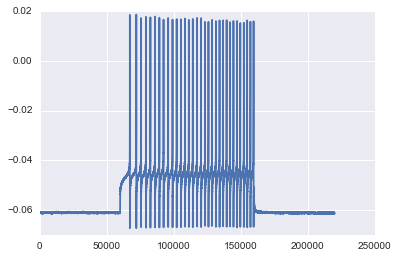

In [56]:
#plt_sweeps(PN_data_sel,0)
figure()
plot(PN_data_sel[0][4])
threshold(PN_data_sel[0][4])

3.2630208879709244

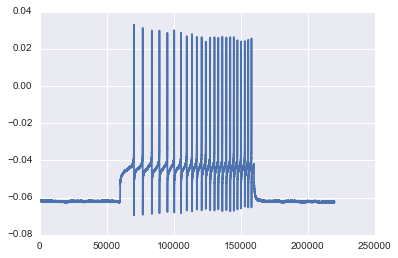

In [57]:
#plt_sweeps(PN_data_sel,1)
figure()
plot(PN_data_sel[1][3])
threshold(PN_data_sel[1][3])

-0.63825765391811728

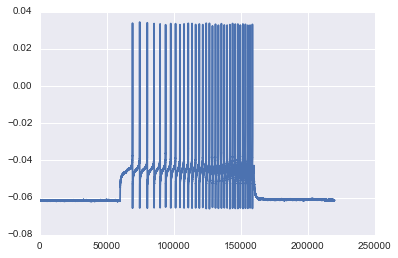

In [58]:
#plt_sweeps(PN_data_sel,2)
figure()
plot(PN_data_sel[2][3])
threshold(PN_data_sel[2][3])

So what should we take as our value of threshold? A mean for each type of neuron over the selected neurons would not be a good measure as the value for threshold is consistent for each specific neuron. Perhaps it is only possible to characterise a threshold for a particular neuron... 

### [Time Constant $\tau_m$](#Contents)


The time constant is calculated from the subthreshold data. We define the time constant to be the time it takes for the membrane potential $V_m$ to reach $1-\frac{1}{e}$ of its maximum value. Looking at the subthreshold data for the LNs and PNs.

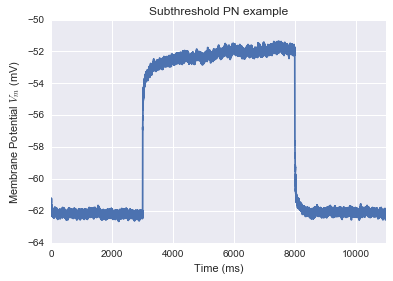

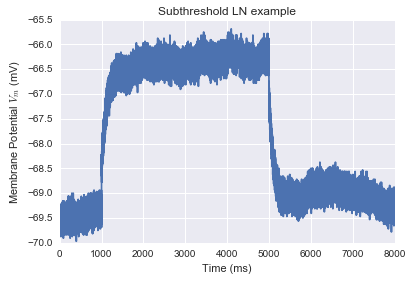

In [59]:
Tpn = 220000*dt
Tln = 160000*dt
tpn = np.arange(0,Tpn,dt)
tln = np.arange(0,Tln,dt)

figure()
plot(tpn*1e3,PN_data[0][0]*1e3)
xlabel('Time (ms)')
xlim(0,11000)
title('Subthreshold PN example')
ylabel('Membrane Potential $V_m$ (mV)')
show()

figure()
plot(tln*1e3,LN_data[0][1]*1e3)
xlabel('Time (ms)')
ylabel('Membrane Potential $V_m$ (mV)')
title('Subthreshold LN example')
show()

There are clearly some features in the membrane potential over a longer timescale than the time constant, which we expect to be over the order of 10 ms. Therefore to extract the time constant we constant by considering the membrane potential during a much smaller time scale - of the order of 50-60 ms after the beginning of the stimulus. We do this using the ```time_constant``` function.

In [60]:
def time_constant(sub_thresh_sweep,stim_start):
    """
    Function to take a subthreshold sweep of either LNs or PNs and return the time constant using the above definition
    in ms
    
    Inputs:
    -------
    sub_thresh_sweep : an array containing the data for a subthreshold sweep.
    stim_start : float, time in seconds of when the stimulus starts
    
    Outputs:
    --------
    time_constant : float (ms)
    """
    hundred_ms = 100
    idx_hundred_ms = 100/(dt*1e3)
    idx_stim_start= int(stim_start/dt)

    V = sub_thresh_sweep
    
    V_time_constant = np.empty_like(V)  #bit of membrane potential which we want to calculate the time constant from
    V_time_constant[:] = V
    
    V_time_constant = V_time_constant[idx_stim_start:int(idx_stim_start+idx_hundred_ms)]
    
    V_time_constant = V_time_constant-min(V_time_constant)
    
    # now find the membrane potential which corresponds to time constant

    tau_Vm = 0.66 * max(V_time_constant)
    
    # find the corresponding time for this potential
    tau_idx = []
    for voltages in range(len(V_time_constant)):
        if V_time_constant[voltages] >= tau_Vm:
            tau_idx.append(voltages)
    
    return tau_idx[0]*dt*1e3

check time constants for PNs and LNs (in ms)



In [98]:
#PNs 

#remember can only consider subthreshold sweeps to extract time constant

sub_thresh_sweeps_PN = []


PNidx = [0,1,2,3,4]
for data in PNidx:
    sub_thresh_sweeps_PN.append(PN_data[data][0])

    
PN_time_constants = []

for data in range(len(sub_thresh_sweeps_PN)):
    PN_time_constants.append(time_constant(sub_thresh_sweeps_PN[data],stim_start_PN))
print PN_time_constants # ms


#LNs, generally consider second sweep as first one has no stim

sub_thresh_sweeps_LN = []


LNidx = [0,1,2,3,4,5,6,7]
for data in LNidx:
    sub_thresh_sweeps_LN.append(LN_data[data][1])

    
LN_time_constants = []

for data in range(len(sub_thresh_sweeps_LN)):
    LN_time_constants.append(time_constant(sub_thresh_sweeps_LN[data],stim_start_LN))
print LN_time_constants # ms



[5.45, 10.5, 8.55, 7.3, 13.15]
[12.85, 16.8, 6.25, 15.700000000000003, 23.85, 12.8, 6.800000000000001, 18.3]


For PNs it seems that we should ignore the first and fifth neurons as the rest of the time constants are clustered around 8 ms (which is approximately the expeced order of magnitude). This gives credence to our selection of 'good' neurons earlier.

fo LNs only 3/4 of the neurons considered have time constants of a similar order of magnitude to that which is expected ~ 10 ms: I chose to consider the first the sixth and the seventh neurons in our analysis. 

In [103]:
#PNs 

#remember can only consider subthreshold sweeps to extract time constant

sub_thresh_sweeps_PN = []


PNidx = [1,2,3]
for data in PNidx:
    sub_thresh_sweeps_PN.append(PN_data[data][0])

    
PN_time_constants = []

for data in range(len(sub_thresh_sweeps_PN)):
    PN_time_constants.append(time_constant(sub_thresh_sweeps_PN[data],stim_start_PN))
print 'Time Constants for selected PNs (ms)',PN_time_constants # ms



#LNs, generally consider second sweep as first one has no stim

sub_thresh_sweeps_LN = []


LNidx = [0,5,6]
for data in LNidx:
    sub_thresh_sweeps_LN.append(LN_data[data][1])

    
LN_time_constants = []

for data in range(len(sub_thresh_sweeps_LN)):
    LN_time_constants.append(time_constant(sub_thresh_sweeps_LN[data],stim_start_LN))
print 'Time Constants for selected LNs (ms)',LN_time_constants # ms


Time Constants for selected PNs (ms) [10.5, 8.55, 7.3]
Time Constants for selected LNs (ms) [12.85, 12.8, 6.800000000000001]


### [Membrane Resistance $R_m$](#Contents)

The membrane resistance can be calculated in the limit for long times, where the solution to the LIF differential equation reduces to 

$$V_h = E_l + R_mI_h $$

This requires knowledge of the holding current, which we only have access to for the LNs. If we know the holding current, then membrane resistance is simply

$$ R_m = \frac{V_h - E_l}{I_h} = \frac{\Delta V}{I_h} $$

where $I_h$ is the holding current and $V_h$ is the holding potential. This is before the 50pA depolarising steps are applied. When these are applied the equation goes to

$$V_s - V_h = R_m I_s $$

$$R_m = \frac{V_s - V_h}{I_s} $$

where the $s$ subscript stands for subthreshold. Using the latter equation we can calculate $R_m$ and subsequently $C_m$ using the time constant. We calculate the $R_m$ using the ```resistance ``` function.

In [63]:
def resistance(V0, subthres_sweep, I_s, tmin, tmax):
    """
    Function to take a subthreshold sweep and return the membrane resistance
    
    Inputs:
    -------
    sub_thresh_sweep : single sweep without stimulation (array) [V]
    I_s  : subthreshold current (pA)
    tmin : float (s) used to define window in which to calculate the subthreshold potential
    tmax : float (s) '' '' 
    V0   : reference potential [V](can find using equilibrium function)
    
    
    Outputs:
    --------
    membrane resistance in M Ohm: float, membrane resistance
    
    """
    
    idx_start = int(tmin/dt)
    idx_end = int(tmax/dt)
    
    V_s = subthres_sweep[idx_start:idx_end]
    R_m = (V_s.mean() - V0) /I_s #tera Ohm [V/pA]
    R_m *= 1e6 #convert to mega Ohm
    return R_m

We can now check that the resistance is broadly consistent over different sweeps.

#### Printing values of membrane resistance for all the LNs

In [64]:
nidx = 5
sub_sweeps = (1,2,3,4)

nidx = 3
sub_sweeps = (1,2,3,4,5)
sweep_idx  = 1

curr_step = 50 #pA
LN_resistances = []


#finding resistances for the second sweep for all the neurons
for data in LN_data:
    Vh = data[sweep_idx,:idx_stim_start_LN].mean()
    R_M = resistance(Vh,data[sweep_idx],curr_step,stim_start_LN+2,stim_end_LN)
    print 'Vh: {:.2f} mV, R_M: {:.2f} MOhm'.format(Vh*1e3,R_M)  
    LN_resistances.append(R_M)
    
    
#finding resistances for all sweeps of a given neuron
for sweep_idx in sub_sweeps:
    Vh = LN_data[nidx][sweep_idx,:idx_stim_start_LN].mean()
    R_M = resistance(Vh,LN_data[nidx][sweep_idx],50*sweep_idx,stim_start_LN+2,stim_end_LN)
    #print 'Vh: {:.2f} mV, R_M: {:.2f} MOhm'.format(Vh*1e3,R_M)    
    LN_resistances.append(R_M)

Vh: -69.45 mV, R_M: 63.50 MOhm
Vh: -69.05 mV, R_M: 58.25 MOhm
Vh: -68.83 mV, R_M: 38.98 MOhm
Vh: -69.51 mV, R_M: 30.60 MOhm
Vh: -66.93 mV, R_M: 292.00 MOhm
Vh: -69.23 mV, R_M: 46.69 MOhm
Vh: -67.42 mV, R_M: 59.27 MOhm
Vh: -67.82 mV, R_M: 45.39 MOhm


Of the selected LN neurons, 

In [65]:
LN_resistances_selected = [LN_resistances[i] for i in (1,5,6)]

print LN_resistances_selected

[58.249831199645996, 46.688765287399292, 59.266090393066406]


##### Print Values of Membrane Resistance for all the PNs


In [121]:
sweep_idx = 1 # second sweep usually has a subthres stimulation

sub_sweeps = (1,2,3,5,6,7)
sub_sweeps = (0,1,2,3,4,5,6)
curr_step = 50 #pA

#finding resistances for the second sweep for all the neurons
PN_resistances = []
for data in PN_data:
    Vh = data[sweep_idx,:idx_stim_start_PN].mean()
    R_M = resistance(Vh,data[sweep_idx],curr_step,stim_start_PN+2,stim_end_PN)
    #print 'Vh: {:.2f} mV, R_M: {:.2f} MOhm'.format(Vh*1e3,R_M)  
    PN_resistances.append(R_M)


#finding resistances for all the sweeps of a given neuron

for sweep_idx in sub_sweeps:
    Vh = PN_data[nidx][sweep_idx,:idx_stim_start_PN].mean()
    R_M = resistance(Vh,PN_data[nidx][sweep_idx],50*sweep_idx,stim_start_PN+2,stim_end_PN)
    #print 'Vh: {:.2f} mV, R_M: {:.2f} MOhm'.format(Vh*1e3,R_M)    



The resistances appear to be largely consistent for each type of neuron.

Similarly for our selected PNs, based on how their time constants behaved we find:

In [122]:
#resistaces of selected PNs
PN_resistances_selected = [PN_resistances[i] for i in (2,3,4)]
print PN_resistances_selected

[256.01230561733246, 286.91716492176056, 273.31911027431488]


### [Membrane Capacitance $C_m$](#Contents)

Membrane capacitance can now be calculated from the time constant using $\tau = R_mCm$. The calculation is contained in the function ``` capacitance```

In [68]:
def capacitance(membrane_resistance,time_constant):
    """
    Function to return the membrane capacitance in nano Farads (nF)
    
    Inputs:
    -------
    membrane_resistance : float, membrane resistance calculated for a particular sweep (gOhms)
    time_constant : float time constant tau for a particular sweep
    
    Outputs:
    membrane capacitance : float, membrane capacitance for a particular sweep (nF)
    """
    
    C_m = time_constant/membrane_resistance
    return C_m


Using this function, let's find the capacitances for our selected LNs and PNs. 

In [124]:
#LNs

capacitancesLN = [capacitance(LN_resistances_selected[i],LN_time_constants[i]) for i in (0,1,2)]
print 'Capactiances of selected LNs (nF)',capacitancesLN #nF
#PNs
capacitancesPN = [capacitance(PN_resistances_selected[i],PN_time_constants[i]) for i in (0,1,2)]
print 'Capacitances of selected PNs (nF)',capacitancesPN #nF

Capactiances of selected LNs (nF) [0.22060149764138876, 0.27415588999211676, 0.11473677367447101]
Capacitances of selected PNs (nF) [0.041013653522165433, 0.029799541628440042, 0.026708706876271492]


the capacitances too are broadly consistent over neuron type

### [Leak Potential $E_l$ & Holding Current](#Contents)

The equilibirum potential $V_{h}$ is approximately -70 mV, however this is after being subject to a holding current. This is done to ensure that different neurons being tested are comparable. We can correct the equilibrium potentials using our knowledge of the holding current in order to find out what they actaully is for the neurons examined.


$$V_h = V_{L} + R_mI_h $$

$$ V_{L} = V_h - R_mI_h  $$ 


In [126]:
#LN averaged holding potentials
for sweeps in LN_data:
    print mean_equilibrium(sweeps,stim_start_LN)  # (V)

(-0.069631249, 0.00049357786)
(-0.071308218, 0.0022116113)
(-0.069785804, 0.0010620955)
(-0.069742247, 0.00058150908)
(-0.066730991, 0.00025949237)
(-0.068096809, 0.0010139332)
(-0.067810819, 0.00063142186)
(-0.067226626, 0.00049897091)


In [127]:
#PN averaged holding potentials
for sweeps in PN_data:
    print mean_equilibrium(sweeps,stim_start_PN) # (V)

(-0.062209204, 0.00021388977)
(-0.060010385, 0.00053257373)
(-0.061227717, 0.00013420917)
(-0.062195785, 0.00065517804)
(-0.061672121, 0.00024668168)


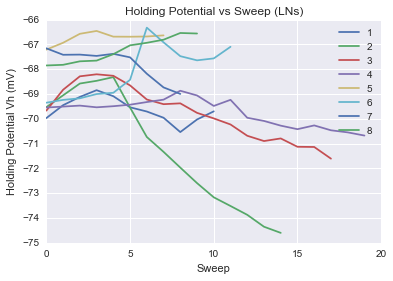

In [72]:
for i,sweeps in enumerate(LN_data):
    plot(sweeps[:,:idx_stim_start_LN].mean(-1)*1e3, label=i+1)

xlabel('Sweep')
ylabel('Holding Potential Vh (mV)')
title('Holding Potential vs Sweep (LNs)')
legend()

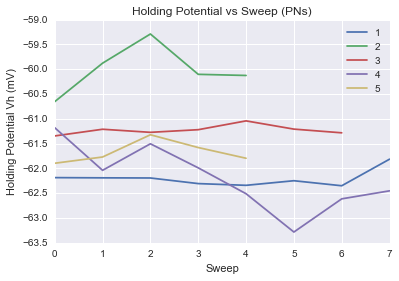

In [73]:
for i,sweeps in enumerate(PN_data):
    plot(sweeps[:,:idx_stim_start_PN].mean(-1)*1e3, label=i+1)

xlabel('Sweep')
ylabel('Holding Potential Vh (mV)')
title('Holding Potential vs Sweep (PNs)')
legend()

By plotting the holding potentials of the LNs and PNs as a function of sweep, we can see that the neurons we ignored for in the LN recordings correspond to neurons that show a rapid decrease in holding potential with increasing numbers of sweeps. This might correspond to a cell dying, and it further adds to the case to ignore these readings in calculating our estimated model parameters.

In [74]:
# Get the Leak potentials (apply holding current correction) (single subthreshold sweep)

In [75]:
sweep_idx = 1
curr_step = 50 #pA

for sweeps in LN_data:    
    V_h = sweeps[sweep_idx,:idx_stim_start_LN].mean()
    R_m = resistance(V_h, sweeps[sweep_idx], curr_step, stim_start_LN+2, stim_end_LN)
    R_m *= 1e6 #convert to Ohm
    V_L = V_h - (R_m*holding_currents[nidx]*1e-12)
    print 'V_h: {:.2f} mV, V_L: {:.2f} mV'.format(V_h*1e3,V_L*1e3)    

V_h: -69.45 mV, V_L: -70.72 mV
V_h: -69.05 mV, V_L: -70.22 mV
V_h: -68.83 mV, V_L: -69.61 mV
V_h: -69.51 mV, V_L: -70.12 mV
V_h: -66.93 mV, V_L: -72.77 mV
V_h: -69.23 mV, V_L: -70.17 mV
V_h: -67.42 mV, V_L: -68.61 mV
V_h: -67.82 mV, V_L: -68.72 mV


### [Single Neuron Model](#Contents)

Now that we've extracted some realistic parameters from our data we can try and incorporate them in a spiking model using the LIF equation. We can start with the model parameters for the PNs. (except threshold)
 


#### Single Neuron Model (PNs)

In [87]:
def stimulus(n_sweeps,sweep_idx):
    """
    Function to return an array of stimulus values for a particular neuron recording (pA)
    
    Inputs:
    -------
    n_sweeps : float, number of sweeps in the recording of one neuron
    sweep_idx : float, the sweep that you want to find the stimulation current for (pA)
    
    Outputs: 
    --------
    
    I : stimulation current for that particular sweep (pA)
    

    """
    curr_step = 50 #pA
    return np.arange(curr_step,n_sweeps*curr_step,curr_step)[sweep_idx]
    

In [88]:
## setup parameters and state variables
T       =  stim_end_PN - stim_start_PN  # total time of stimulation (s)

dt      = 1/f_s                         # time step (Hz)

tsim    = np.arange(0,T+dt,dt)          # time array

tref    = 0                             # refractory time

In [89]:
## LIF properties

Vm            = np.zeros(len(tsim))                    # potential (V) over time
Cm            = np.mean(capacitancesPN)                # membrane capacitance (nF)
Rm            = np.mean(PN_resistances_selected)       # membrane resistance (MOhms)
tau_m         = Rm*Cm                                  # membrane time constant (ms)
Vth           = 0                                      # threshold voltage (V) (need's fixing)
V_spike       = 0.5                                    # spike 'delta' as observed spikes have
                                                       # some form

## stimulus

#I = stimulus()                                        # define stimulus here, input current pA

In [ ]:
## iterate over each time step
    